In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
rfmMoreCut = pd.read_csv('morefeaCut/rfmMoreCut.csv')
rfmMoreCut=rfmMoreCut.set_index('会员编号')

In [3]:
rfmMoreCut.head()

,money,recent,frequency,sex,age
会员编号,,,,,
1027478498,439.5,4,20,2,21
1030794986,1.0,57,1,1,37
1030797014,248.0,38,15,1,31
1030904479,4.0,50,2,2,36
1033252014,1309.0,39,29,2,36


In [4]:
rfm_log = rfmMoreCut[['money', 'recent','frequency','sex','age']].apply(np.log, axis = 1).round(2)
rfm_log.describe()

,money,recent,frequency,sex,age
count,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000
mean,6.827190,2.693690,3.086415,0.382006,3.464037
std,0.763662,0.943848,0.303960,0.343042,0.237059
min,0.000000,0.000000,0.000000,0.000000,2.400000
25%,6.390000,2.200000,2.940000,0.000000,3.330000
50%,6.880000,3.000000,3.090000,0.690000,3.470000
75%,7.350000,3.430000,3.260000,0.690000,3.610000
max,8.520000,4.090000,4.500000,0.690000,4.810000


In [5]:
#rfm_log_zs = (rfm_log -rfm_log.mean())/rfm_log.std()
#rfm_log_zs.describe()
# cancel zs
rfm_log_zs = rfm_log

In [6]:
from sklearn.metrics import pairwise
class KernelKMeans(object):

    def __init__(self,
                 n_clusters=8,
                 max_iter=300,
                 kernel=pairwise.linear_kernel):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.kernel = kernel

    def _initialize_cluster(self, X):
        self.N = np.shape(X)[0]
        self.y = np.random.randint(low=0, high=self.n_clusters, size=self.N)
        self.K = self.kernel(X)

    def fit_predict(self, X):
        self._initialize_cluster(X)
        for _ in range(self.max_iter):
            obj = np.tile(np.diag(self.K).reshape((-1, 1)), self.n_clusters)
            N_c = np.bincount(self.y)
            for c in range(self.n_clusters):
                obj[:, c] -= 2 * \
                    np.sum((self.K)[:, self.y == c], axis=1) / N_c[c]
                obj[:, c] += np.sum((self.K)[self.y == c][:, self.y == c]) / \
                    (N_c[c] ** 2)
            self.y = np.argmin(obj, axis=1)
        return self.y

In [8]:
def plotPie(rfm_kn, label,title, method, clusterNum, saveDir='kernelKmeans'):
    customer_label_method = rfm_kn.groupby('cluster').agg({label: method})
    labelSizes = customer_label_method[label].to_numpy()
    #frequencyExplode = (0, 0, 0)
    labels = ['cluster{}'.format(i) for i in range(clusterNum)]
    plt.figure()
    plt.pie(labelSizes, labels = labels, autopct='%1.1f%%', shadow = False, startangle = 90)
    plt.title('{} proportion({})'.format(title,method))
    plt.savefig('{}/cluster{}{}Proportion_{}'.format(saveDir,clusterNum,title,method))
def clusterKernelKmeans(clusterNum, rfmMorecut, rfm_log_zs):
    model = KernelKMeans(n_clusters = clusterNum, max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
    cluster_labels = model.fit_predict(rfm_log_zs)
    rfm_kn = rfmMoreCut.assign(cluster = cluster_labels)
    return rfm_kn

In [9]:
# clusterNum =6
rfm_kn6 = clusterKernelKmeans(6, rfmMoreCut, rfm_log_zs)
rfm_kn_6_describe=rfm_kn6.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

In [15]:
#plotPie(rfm_kn6, 'money', 'User', 'count',6, 'kernelKmeansNonormalize')
#plotPie(rfm_kn6, 'money', 'Value', 'sum', 6, 'kernelKmeansNonormalize')
#plotPie(rfm_kn6, 'money', 'Value', 'mean', 6, 'kernelKmeansNonormalize')
#plotPie(rfm_kn6, 'frequency', 'frequency', 'mean', 6, 'kernelKmeansNonormalize')
#plotPie(rfm_kn6, 'recent', 'recent', 'mean', 6, 'kernelKmeansNonormalize')
rfm_kn_6_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        2049.45   609   7.79     29.50
1         826.93  1578  24.39     20.88
2         276.37   753  35.66     15.99
3         729.31   702   7.76     19.91
4        2030.58  1207  25.20     27.88
5        1284.78   465   1.90     23.78

NameError: name 'rfm_kn' is not defined

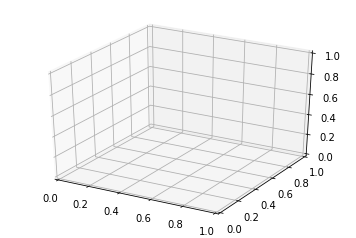

In [16]:
clusterNum = 6
from mpl_toolkits.mplot3d import proj3d
ax = plt.subplot(111, projection = '3d')
color = ['r', 'g', 'k', 'b', 'y', 'm']
for i in range(clusterNum):
    clusterIndex=rfm_kn6.loc[rfm_kn6['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = color[i],label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,5000])
ax.set_ylabel('R')
ax.set_ylim([0,50])
ax.set_zlabel('F')
ax.set_zlim([0, 100])
ax.legend()

In [44]:
clusterNum = 4
model = KernelKMeans(n_clusters = clusterNum, max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
cluster_labels = model.fit_predict(rfm_log_zs)
rfm_kn = rfmMoreCut.assign(cluster = cluster_labels)
rfm_kn_describe=rfm_kn.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

In [45]:
rfm_kn_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        1654.69  2144  24.46     25.88
1        1109.13  1196   8.50     22.74
2        1473.30   582   2.23     25.04
3         423.70  1392  30.86     17.52

In [30]:
rfm_kn_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        1809.56  1227  21.15     27.32
1        1082.39  1984  22.96     22.06
2        1411.84   899   3.89     25.04
3         568.43  1204  26.46     18.14

<IPython.core.display.Javascript object>


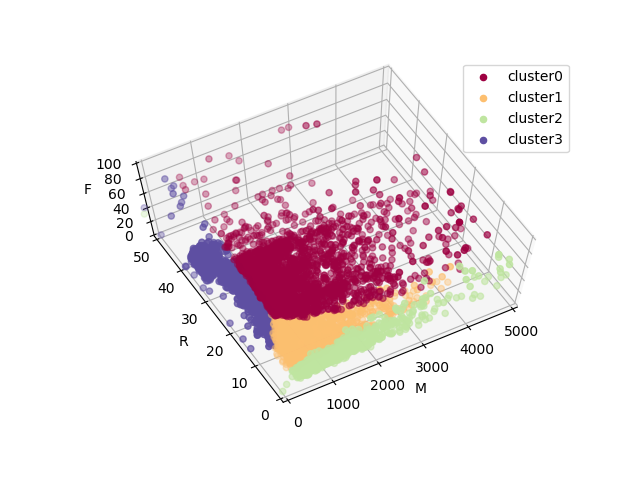

In [46]:
%matplotlib notebook
from mpl_toolkits.mplot3d import proj3d
ax = plt.subplot(111, projection = '3d')
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=3)
for i in range(clusterNum):
    clusterIndex=rfm_kn.loc[rfm_kn['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = cmap(norm(clusterIndex.iloc[0, 5])),label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,5000])
ax.set_ylabel('R')
ax.set_ylim([0,50])
ax.set_zlabel('F')
ax.set_zlim([0, 100])
ax.legend()

In [51]:
clusterNum = 3
model = KernelKMeans(n_clusters = clusterNum, max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
cluster_labels = model.fit_predict(rfm_log_zs)
rfm_kn = rfmMoreCut.assign(cluster = cluster_labels)
rfm_kn_describe=rfm_kn.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

<IPython.core.display.Javascript object>


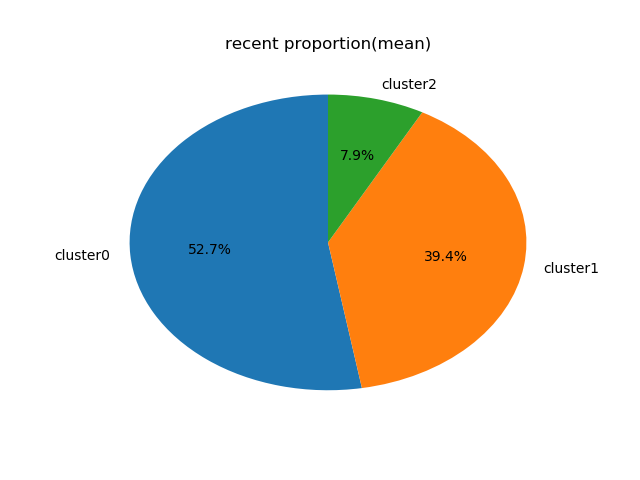

In [57]:
#plotPie(rfm_kn, 'money', 'User', 'count',clusterNum, 'kernelKmeansNonormalize')
#plotPie(rfm_kn, 'money', 'Value', 'sum', clusterNum, 'kernelKmeansNonormalize')
#plotPie(rfm_kn, 'money', 'Value', 'mean', clusterNum, 'kernelKmeansNonormalize')
#plotPie(rfm_kn, 'frequency', 'frequency', 'mean', clusterNum, 'kernelKmeansNonormalize')
plotPie(rfm_kn, 'recent', 'recent', 'mean', clusterNum, 'kernelKmeansNonormalize')

<IPython.core.display.Javascript object>


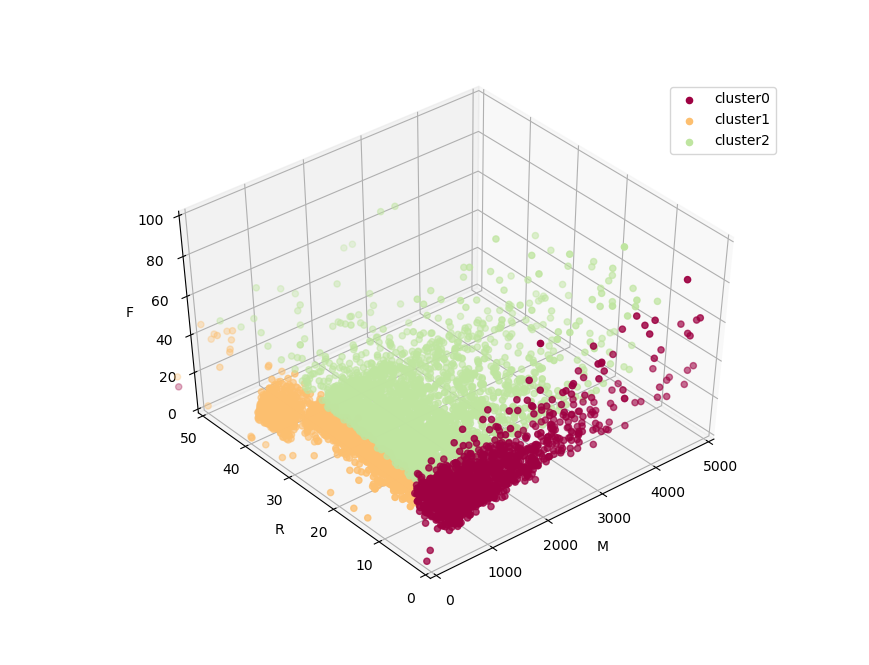

In [17]:

from mpl_toolkits.mplot3d import proj3d
ax = plt.subplot(111, projection = '3d')
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=3)
for i in range(clusterNum):
    clusterIndex=rfm_kn.loc[rfm_kn['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = cmap(norm(clusterIndex.iloc[0, 5])),label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,5000])
ax.set_ylabel('R')
ax.set_ylim([0,50])
ax.set_zlabel('F')
ax.set_zlim([0, 100])
ax.legend()

In [53]:
rfm_kn_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0         437.81  1508  29.75     17.63
1        1598.90  2535  22.22     25.56
2        1265.14  1271   4.44     23.82

In [33]:
# clusterNum =4
rfm_kn4 = clusterKernelKmeans(4, rfmMoreCut, rfm_log_zs)
rfm_kn_4_describe=rfm_kn4.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

In [43]:
#plotPie(rfm_kn4, 'money', 'User', 'count',4, 'kernelKmeansNonormalize')
#plotPie(rfm_kn4, 'money', 'Value', 'sum', 4, 'kernelKmeansNonormalize')
#plotPie(rfm_kn4, 'money', 'Value', 'mean', 4, 'kernelKmeansNonormalize')
#plotPie(rfm_kn4, 'frequency', 'frequency', 'mean', 4, 'kernelKmeansNonormalize')
#plotPie(rfm_kn4, 'recent', 'recent', 'mean', 4, 'kernelKmeansNonormalize')
rfm_kn_4_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        1109.13  1196   8.50     22.74
1        1654.69  2144  24.46     25.88
2        1473.30   582   2.23     25.04
3         423.70  1392  30.86     17.52

In [49]:
plt.close()

In [58]:
# clusterNum =5
rfm_kn5 = clusterKernelKmeans(5, rfmMoreCut, rfm_log_zs)
rfm_kn_5_describe=rfm_kn5.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

In [64]:
#plotPie(rfm_kn5, 'money', 'User', 'count',5, 'kernelKmeansNonormalize')
#plotPie(rfm_kn5, 'money', 'Value', 'sum', 5, 'kernelKmeansNonormalize')
#plotPie(rfm_kn5, 'money', 'Value', 'mean', 5, 'kernelKmeansNonormalize')
#plotPie(rfm_kn5, 'frequency', 'frequency', 'mean', 5, 'kernelKmeansNonormalize')
#plotPie(rfm_kn5, 'recent', 'recent', 'mean', 5, 'kernelKmeansNonormalize')
rfm_kn_5_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0         273.11   740  35.76     15.93
1        1422.04   535   2.06     24.65
2        1140.52  1065   7.52     22.97
3         817.52  1650  24.42     20.81
4        2111.00  1324  23.40     28.60

<IPython.core.display.Javascript object>


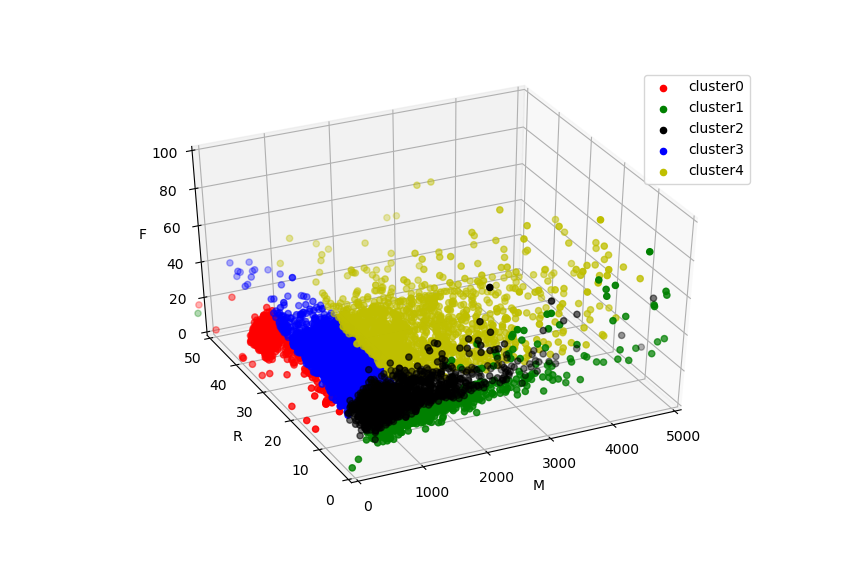

In [71]:
clusterNum = 5
ax = plt.subplot(111, projection = '3d')
color = ['r', 'g', 'k', 'b', 'y']
for i in range(clusterNum):
    clusterIndex=rfm_kn.loc[rfm_kn5['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = color[i],label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,5000])
ax.set_ylabel('R')
ax.set_ylim([0,50])
ax.set_zlabel('F')
ax.set_zlim([0, 100])
ax.legend()

MemoryError: 